In [242]:
#import pandas
import pandas as pd

#import matplotlib
import matplotlib.pyplot as plt
import datetime as dt


# import sqlalchemy
import sqlalchemy

# Imports the method used for connecting to DBs
from sqlalchemy import create_engine

# Imports the methods needed to abstract classes into tables
from sqlalchemy.ext.declarative import declarative_base

# Allow us to declare column types
from sqlalchemy import Column, Integer, String, Float, Date


from sqlalchemy.ext.automap import automap_base

from sqlalchemy.orm import Session

from sqlalchemy import create_engine, inspect

from sqlalchemy import func

In [243]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///hawaii.sqlite")

In [244]:
# inspector to view table value
inspector = inspect(engine)

In [245]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [246]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [247]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [248]:
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

# Assign the station class to a variable called `Station`
Station = Base.classes.station

In [249]:
columns = inspector.get_columns('Measurement')

for column in columns:
    print (column['name'],column['type'])

id INTEGER
station VARCHAR(50)
date VARCHAR(10)
prcp FLOAT
tobs FLOAT


In [250]:
columns = inspector.get_columns('Station')

for column in columns:
    print (column['name'],column['type'])

id INTEGER
station VARCHAR(50)
name VARCHAR(50)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [251]:
# Create a session
session = Session(engine)

In [252]:
compare_date = dt.date.today() - dt.timedelta(days = 365)
print (compare_date)

2017-04-23


### Precipitation Analysis

##### Design a query to retrieve the last 12 months of precipitation data.
##### Select only the date and prcp values.
##### Load the query results into a Pandas DataFrame and set the index to the date column.
##### Plot the results using the DataFrame plot method.

In [253]:
precipitation_list = []
date_list = []

sel = [Measurement.date, 
       Measurement.prcp
       ]

precipitation_analysis = session.query(*sel).filter((Measurement.date >= compare_date) 
                                      ).order_by(Measurement.date).all()

for row in precipitation_analysis:
    date_list.append(row[0])
    precipitation_list.append(row[1])

precipitation_analysis_df = pd.DataFrame({"precipitation":precipitation_list,
                                       "date":date_list})

precipitation_analysis_df.head()

,date,precipitation
0,2017-04-23,0.03
1,2017-04-23,0.02
2,2017-04-23,0.06
3,2017-04-23,0.35
4,2017-04-24,0.00


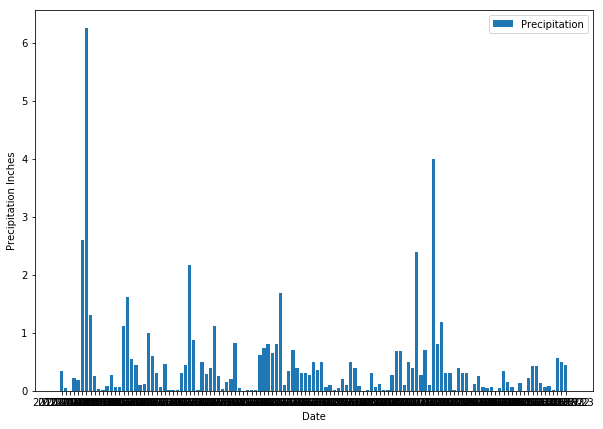

In [254]:
plt.figure(figsize = (10, 7))
plt.subplot()
plt.bar(precipitation_analysis_df["date"], precipitation_analysis_df["precipitation"], label = "Precipitation")
#ax.set_xticks(precipitation_analysis_df["date"])

plt.legend()
plt.ylabel("Precipitation Inches")
plt.xlabel("Date")
plt.show()

### Station Analysis

In [255]:
#Design a query to calculate the total number of stations.

total_number_of_stations = session.query(Station).count()
print (f"The total nbr of sations are {total_number_of_stations}")

The total nbr of sations are 9


In [256]:
#List the stations and observation counts in descending order.
station_observation = session.query(Measurement.station, func.count(Measurement.station).label('Total')
                                    ).group_by(Measurement.station).order_by('Total DESC')
for row in station_observation:
    print (row)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


C:\Users\kisho\Anaconda3\envs\pythondata\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'Total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [257]:
#Which station has the highest number of observations?
print(f"The station {station_observation[0][0]} has the highest nbr of observation count: {station_observation[0][1]}")
print(" ")

The station USC00519281 has the highest nbr of observation count: 2772
 


C:\Users\kisho\Anaconda3\envs\pythondata\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'Total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [258]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
        # Filter by the station with the highest number of observations.
        # Plot the results as a histogram with bins = 12.
temp_list = []
date_list= []

sel =   [Measurement.tobs,
        Measurement.date
        ]

station_with_highest_observation = session.query(*sel).filter(
    (Measurement.date >=  compare_date) & (Measurement.station == 
                                           station_observation[0][0])).all()

for row in station_with_highest_observation:
    temp_list.append(row[0])
    date_list.append(row[1])

tobs_for_station_df = pd.DataFrame({"Temperature":temp_list,
                                                   "date":date_list
                                                   })

tobs_for_station_df.head()
print(" ")

C:\Users\kisho\Anaconda3\envs\pythondata\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'Total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


C:\Users\kisho\Anaconda3\envs\pythondata\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'Total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


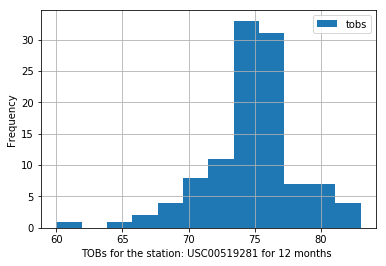

In [259]:
plt.hist(tobs_for_station_df["Temperature"],
         bins = 12, label = "tobs")
plt.ylabel("Frequency")
plt.xlabel(f"TOBs for the station: {station_observation[0][0]} for 12 months ")
plt.legend()
plt.grid()
plt.show()
print(" ")

#### Temperature Analysis


Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

Plot the min, avg, and max temperature from your previous query as a bar chart.


Use the average temperature as the bar height.
Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [260]:
def calc_temps (start_date, end_date):
    sel =[func.min(Measurement.tobs),
          func.avg(Measurement.tobs),
          func.max(Measurement.tobs),
         ]
    
    temperature_values = session.query(*sel).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
    return temperature_values

trip_start_date = '2017-05-27'
trip_end_date = '2017-06-10'
trip_temperature_values = calc_temps(trip_start_date, trip_end_date)

min_temp = trip_temperature_values[0][0]
avg_temp = round(trip_temperature_values[0][1],1)
max_temp = trip_temperature_values[0][2]

print(f"Minimum Temperature: {min_temp}" )
print(f"Average Temperature: {avg_temp}" )
print(f"Maximum Temperature: {max_temp}" )

Minimum Temperature: 69.0
Average Temperature: 77.1
Maximum Temperature: 82.0


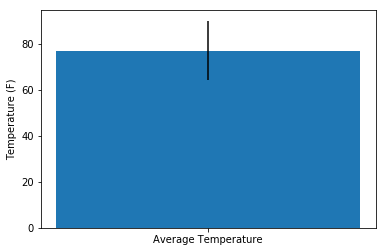

In [261]:
# This is looking at the average temperature
ax = plt.subplot()

ax.bar(range(1), avg_temp,width=0.35, yerr = [max_temp - min_temp])
ax.set_xticks(range(1))
ax.set_xticklabels(["Average Temperature"])
plt.ylabel("Temperature (F)")
plt.show()

### Optional Recommended Analysis

    Calcualte the rainfall per weather station using the previous year's matching dates.

In [262]:
sel = [Measurement.prcp, Measurement.station]
rainfall_per_weather_station = session.query(*sel).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()




### Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

    Create a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.

    Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
    
    Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

    Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [263]:
def daily_normals(input_date_mmdd):
    sel = [func.min(Measurement.tobs),
           func.max(Measurement.tobs),
           func.avg(Measurement.tobs)
          ]
    
    temp_values = session.query(*sel).filter(Measurement.date.contains(input_date_mmdd)).all()
    
    
    daily_min = temp_values[0][0]
    daily_max = temp_values[0][1]
    daily_avg = round(temp_values[0][2],2)
    daily_normal = round((temp_values[0][0] + temp_values[0][1] + temp_values[0][2]) / 3,2)
    
    return daily_normal,daily_min,daily_max,daily_avg

trip_list_date = ["06-15","06-16","06-17","06-18","06-19","06-20","06-21","06-22","06-23","06-24","06-25"]

trip_daily_normal_temperature = []
trip_daily_min_temperature = []
trip_daily_max_temperature = []
trip_daily_avg_temperature = []

for trip_date in trip_list_date:
    daily_normal,daily_min,daily_max,daily_avg = daily_normals(trip_date)
    trip_daily_normal_temperature.append(daily_normal)
    trip_daily_min_temperature.append(daily_min)
    trip_daily_max_temperature.append(daily_max)
    trip_daily_avg_temperature.append(daily_avg)

print(trip_daily_normal_temperature)

trip_daily_normal_df = pd.DataFrame({"date":trip_list_date,
                  "normal_temp":trip_daily_normal_temperature,
                  "daily_min":trip_daily_min_temperature,
                  "daily_max":trip_daily_max_temperature,
                  "daily_avg":trip_daily_avg_temperature,
                  })

trip_daily_normal_df.set_index("date")

[75.19, 75.08, 74.52, 74.52, 75.81, 75.59, 74.88, 75.1, 74.13, 75.62, 74.03]


,daily_avg,daily_max,daily_min,normal_temp
date,,,,
06-15,75.57,81.0,69.0,75.19
06-16,75.24,81.0,69.0,75.08
06-17,74.57,81.0,68.0,74.52
06-18,74.57,80.0,69.0,74.52
06-19,75.42,82.0,70.0,75.81
06-20,73.78,85.0,68.0,75.59
06-21,74.64,82.0,68.0,74.88
06-22,75.31,81.0,69.0,75.10
06-23,74.39,80.0,68.0,74.13


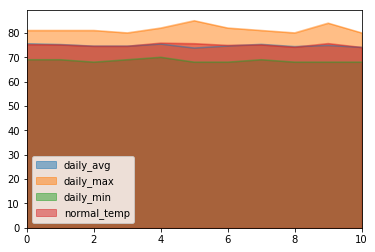

In [264]:
trip_daily_normal_df.plot(kind='area',stacked=False)
plt.figure(figsize = (10,10))
plt.show()